Reproducing a [tweeted graph](https://twitter.com/pgildersleve/status/1568678018490531840) as a fact check for the Communications team before they tweeted it.

In [29]:
import matplotlib as mpl
import pandas as pd

import wmfdata as wmf
from wmfdata.utils import (
    pd_display_all,
    df_to_remarkup,
    pct_str
)

In [2]:
e2_views = wmf.spark.run("""
SELECT
    year,
    month,
    day,
    hour,
    project_url,
    article_title,
    SUM(view_count) AS views
FROM nshahquinn.elizabeth_ii_articles ea
LEFT JOIN wmf.pageview_hourly ph
ON
    REPLACE(ea.project_url, '.org', '') = ph.project
    AND REPLACE(ea.article_title, ' ', '_') = ph.page_title
WHERE
    agent_type = 'user'
    AND year = 2022
    AND month = 9
    AND (
        day = 7 AND hour >= 20
        OR day = 8
        OR day = 9
        OR day = 10 AND hour < 8
    )
GROUP BY
    year,
    month,
    day,
    hour,
    project_url,
    article_title
""")

PySpark executors will use /usr/lib/anaconda-wmf/bin/python3.


PYSPARK_PYTHON=/usr/lib/anaconda-wmf/bin/python3


SLF4J: Class path contains multiple SLF4J bindings.
SLF4J: Found binding in [jar:file:/usr/lib/spark2/jars/slf4j-log4j12-1.7.16.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: Found binding in [jar:file:/usr/lib/hadoop/lib/slf4j-log4j12-1.7.25.jar!/org/slf4j/impl/StaticLoggerBinder.class]
SLF4J: See http://www.slf4j.org/codes.html#multiple_bindings for an explanation.
SLF4J: Actual binding is of type [org.slf4j.impl.Log4jLoggerFactory]
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/09/12 18:28:03 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/09/12 18:28:03 WARN Utils: Service 'sparkDriver' could not bind on port 12000. Attempting port 12001.
22/09/12 18:28:03 WARN Utils: Service 'sparkDriver' could not bind on port 12001. Attempting port 12002.
22/09/12 18:28:03 

In [39]:
key_projects = [
    "en.wikipedia.org",
    "es.wikipedia.org",
    "ru.wikipedia.org",
    "fr.wikipedia.org",
    "de.wikipedia.org"
]

e2_views_for_graphing = (
    e2_views.assign(
        dt=lambda df: (pd.to_datetime(df[["year", "month", "day", "hour"]]) \
            - pd.Timestamp("1970-01-01")) / pd.Timedelta('1d')
    ).groupby(["project_url", "dt"])
    ["views"].sum()
    .to_frame()
    .query("project_url in @key_projects")
    .unstack(level=0)
    .xs("views", axis=1)
    [key_projects]
)

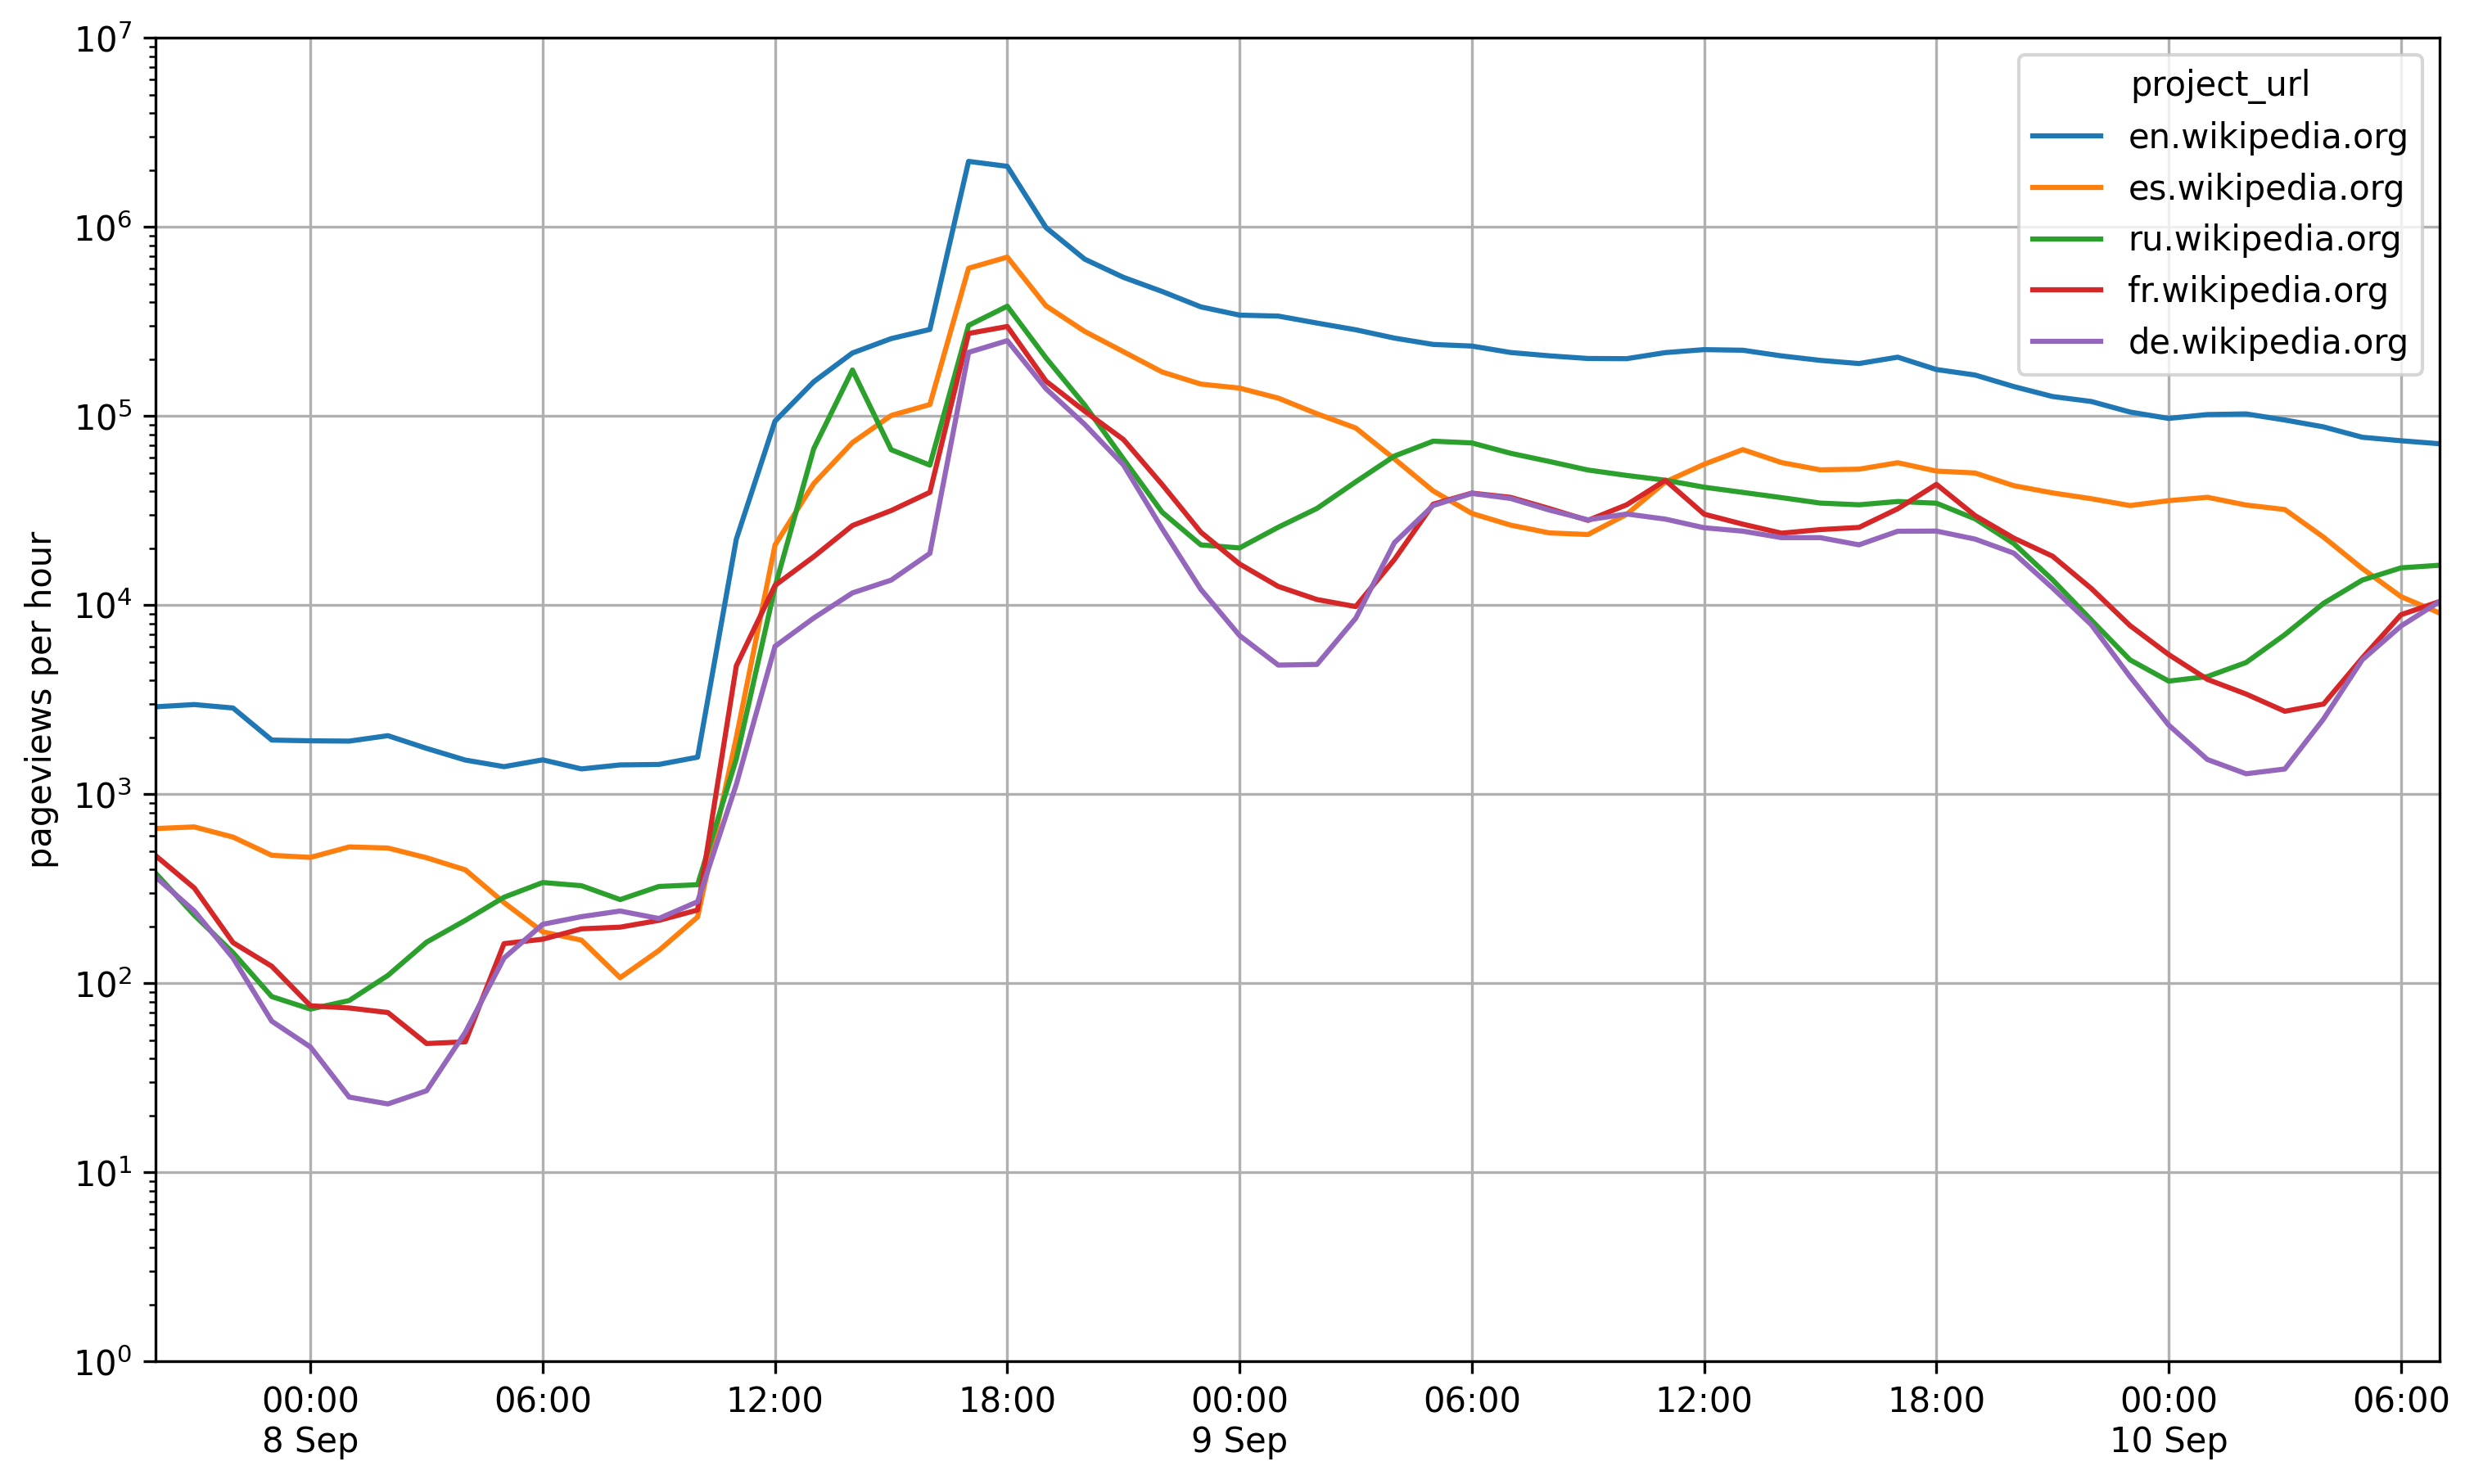

In [48]:
mpl.style.use({
    "axes.grid": True,
    "axes.autolimit_mode": "data",
#    "font.size": 18,
#    "lines.linewidth": 3,
    "figure.figsize": (12, 7),
    "axes.xmargin": 0,
    "axes.ymargin": 0,
    "figure.dpi": 300
})

ax = e2_views_for_graphing.plot(ylim=(1, 10**7))

locator = mpl.dates.AutoDateLocator()
formatter = mpl.dates.ConciseDateFormatter(locator)
formatter.zero_formats[3] = "%H:%M\n%-d %b"
formatter.offset_formats[3] = ""
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

ax.set_yscale("log")

# ax.yaxis.set_major_formatter(skip_0_fmt)

ax.set_xlabel("")
ax.set_ylabel("pageviews per hour");